# Exercise 2 - Classification demand model 

A classification model is a machine learning (ML) technique used to categorize data into different classes.

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC, SVR
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, r2_score, confusion_matrix, mean_absolute_error

from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier, XGBRegressor
from dotenv import load_dotenv

In [2]:
_ = load_dotenv()

## Load data from csv file

In [3]:
path = os.getenv("CLASSIFICATION_PATH")

data = pd.read_csv(path)

data.head()

,autoID,SeniorCity,Partner,Dependents,Service1,Service2,Security,OnlineBackup,DeviceProtection,TechSupport,Contract,PaperlessBilling,PaymentMethod,Charges,Demand,Class
0,7590-VHVEG,0,Yes,No,No,No phone service,No,Yes,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,Alpha
1,5575-GNVDE,0,No,No,Yes,No,Yes,No,Yes,No,One year,No,Mailed check,56.95,1889.5,Alpha
2,3668-QPYBK,0,No,No,Yes,No,Yes,Yes,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Betha
3,7795-CFOCW,0,No,No,No,No phone service,Yes,No,Yes,Yes,One year,No,Bank transfer (automatic),42.30,1840.75,Alpha
4,9237-HQITU,0,No,No,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Betha


### Dataset description

* autoID --> Unique identifier

* SeniorCity --> Bool (0 o 1) whether the person lives in a senior city

* Partner, Dependents, Service1, Service2, Security, OnlineBackup, DeviceProtection, TechSupport, Contract, PaperlessBilling, PaymentMethod --> Categorical variables related to the contracted services and client characteristics.

* Charges --> Service cost (continuous variable).

* Demand --> Continuous target label (Classification interest variable).

* Class --> discrete target label (categories: Alpha, Betha).

In [4]:
data = data.drop("autoID", axis=1)

data.dtypes

SeniorCity            int64
Partner              object
Dependents           object
Service1             object
Service2             object
Security             object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
Contract             object
PaperlessBilling     object
PaymentMethod        object
Charges             float64
Demand               object
Class                object
dtype: object

Demand column is an object type, not a number type (float)

In [5]:
print(data.isnull().sum())

SeniorCity          0
Partner             0
Dependents          0
Service1            0
Service2            0
Security            0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
Contract            0
PaperlessBilling    0
PaymentMethod       0
Charges             0
Demand              0
Class               0
dtype: int64


Null values are not found in the column... We need to approach this situation with a replace

In [6]:
data["Demand"] = data["Demand"].replace(" ", 0)

data["Demand"] = data["Demand"].astype(float)

In [7]:
data.dtypes

SeniorCity            int64
Partner              object
Dependents           object
Service1             object
Service2             object
Security             object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
Contract             object
PaperlessBilling     object
PaymentMethod        object
Charges             float64
Demand              float64
Class                object
dtype: object

Once identified whitespaces in column, they are replaced by 0 

In [8]:
print(data.info())
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SeniorCity        7043 non-null   int64  
 1   Partner           7043 non-null   object 
 2   Dependents        7043 non-null   object 
 3   Service1          7043 non-null   object 
 4   Service2          7043 non-null   object 
 5   Security          7043 non-null   object 
 6   OnlineBackup      7043 non-null   object 
 7   DeviceProtection  7043 non-null   object 
 8   TechSupport       7043 non-null   object 
 9   Contract          7043 non-null   object 
 10  PaperlessBilling  7043 non-null   object 
 11  PaymentMethod     7043 non-null   object 
 12  Charges           7043 non-null   float64
 13  Demand            7043 non-null   float64
 14  Class             7043 non-null   object 
dtypes: float64(2), int64(1), object(12)
memory usage: 825.5+ KB
None
        SeniorCity      

### Descriptive analysis

#### Categorical variables

* Partner
* Dependents
* Service1
* Service2
* Security
* OnlineBackup
* DeviceProtection
* TechSupport
* Contract
* PaperlessBilling
* PaymentMethod
* Class

These variables have values ​​such as 'Yes', 'No', or specific method names

#### Continuous variables

* SeniorCity --> Bool variable (0 or 1).
* Charges and Demand --> Numerical continuous values

In [9]:
cat_vars = data.select_dtypes(include=['object']).columns
print("Categorical variables:", cat_vars)
for var in cat_vars:
    print(f"\n{var}'s distribution:")
    print(data[var].value_counts(normalize=True))

Categorical variables: Index(['Partner', 'Dependents', 'Service1', 'Service2', 'Security',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'Class'],
      dtype='object')

Partner's distribution:
Partner
No     0.516967
Yes    0.483033
Name: proportion, dtype: float64

Dependents's distribution:
Dependents
No     0.700412
Yes    0.299588
Name: proportion, dtype: float64

Service1's distribution:
Service1
Yes    0.903166
No     0.096834
Name: proportion, dtype: float64

Service2's distribution:
Service2
No                  0.481329
Yes                 0.421837
No phone service    0.096834
Name: proportion, dtype: float64

Security's distribution:
Security
No                     0.496663
Yes                    0.286668
No internet service    0.216669
Name: proportion, dtype: float64

OnlineBackup's distribution:
OnlineBackup
No                     0.438450
Yes                    0.344881
No internet service    0.216669
Nam

In [10]:
num_vars = data.select_dtypes(include=['int64', 'float64']).columns
print("Numerical variables:", num_vars)

Numerical variables: Index(['SeniorCity', 'Charges', 'Demand'], dtype='object')


## Exploratory Data Analysis (EDA)

### Correlation analysis

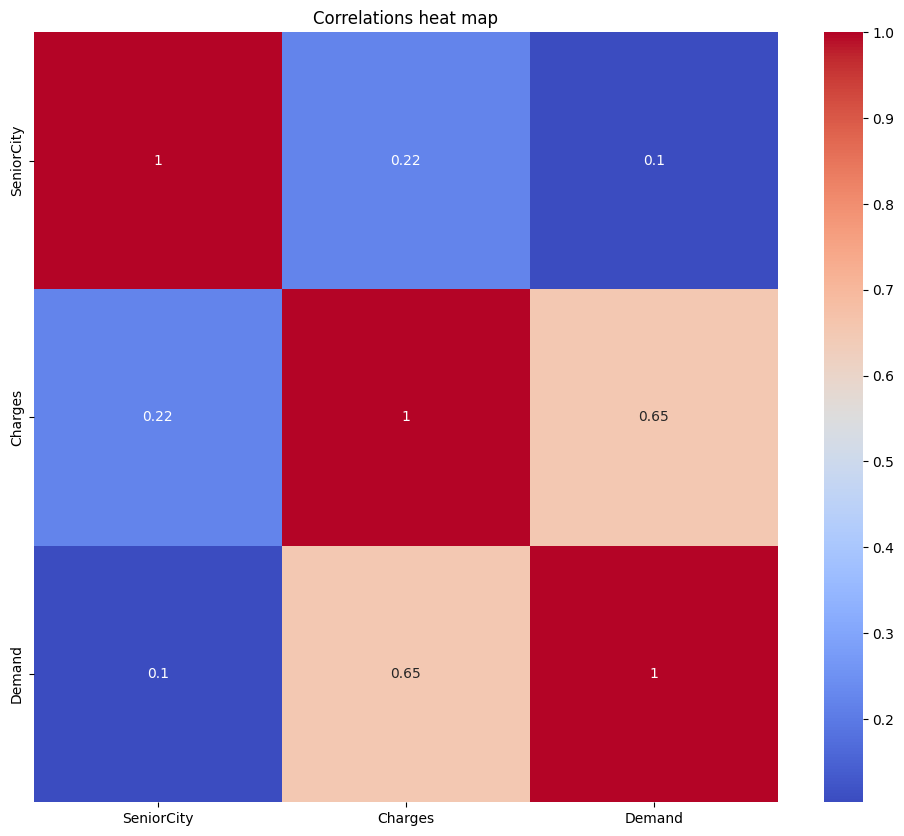

In [11]:
plt.figure(figsize=(12, 10))
sns.heatmap(data[num_vars].corr(), annot=True, cmap='coolwarm')
plt.title('Correlations heat map')
plt.show()

Charges and Demand --> They have a significant positive correlation (0.65). This indicates that Charges are related to Demand

SeniorCity --> It shows no correlation with Charges or Demand (this column will be dropped from data and from numerical variables)

In [12]:
data = data.drop("SeniorCity", axis=1)
num_vars = num_vars.drop(["SeniorCity", "Demand"])

print(data.head())
print(num_vars)

  Partner Dependents Service1          Service2 Security OnlineBackup  \
0     Yes         No       No  No phone service       No          Yes   
1      No         No      Yes                No      Yes           No   
2      No         No      Yes                No      Yes          Yes   
3      No         No       No  No phone service      Yes           No   
4      No         No      Yes                No       No           No   

  DeviceProtection TechSupport        Contract PaperlessBilling  \
0               No          No  Month-to-month              Yes   
1              Yes          No        One year               No   
2               No          No  Month-to-month              Yes   
3              Yes         Yes        One year               No   
4               No          No  Month-to-month              Yes   

               PaymentMethod  Charges   Demand  Class  
0           Electronic check    29.85    29.85  Alpha  
1               Mailed check    56.95  1889.50

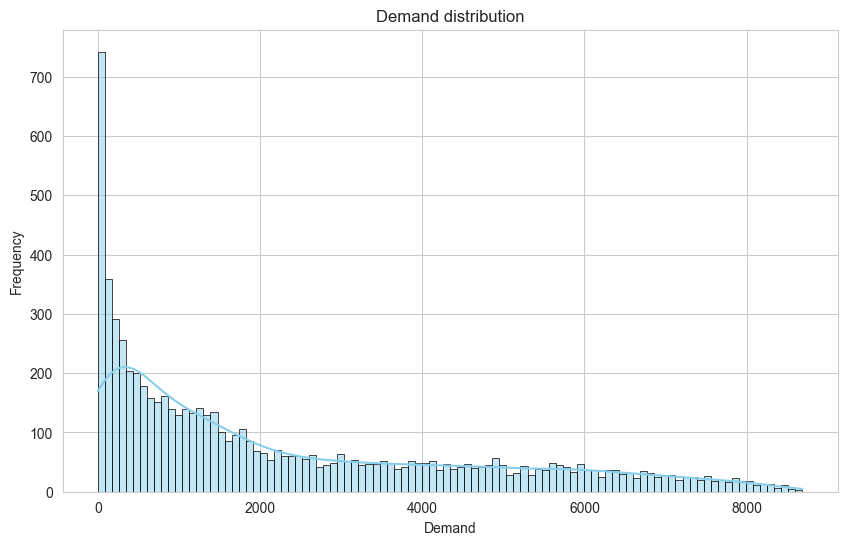

In [13]:
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
sns.histplot(data['Demand'], bins=100, color="skyblue", edgecolor="black", kde=True)
plt.xlabel("Demand")
plt.ylabel("Frequency")
plt.title('Demand distribution')
plt.show()

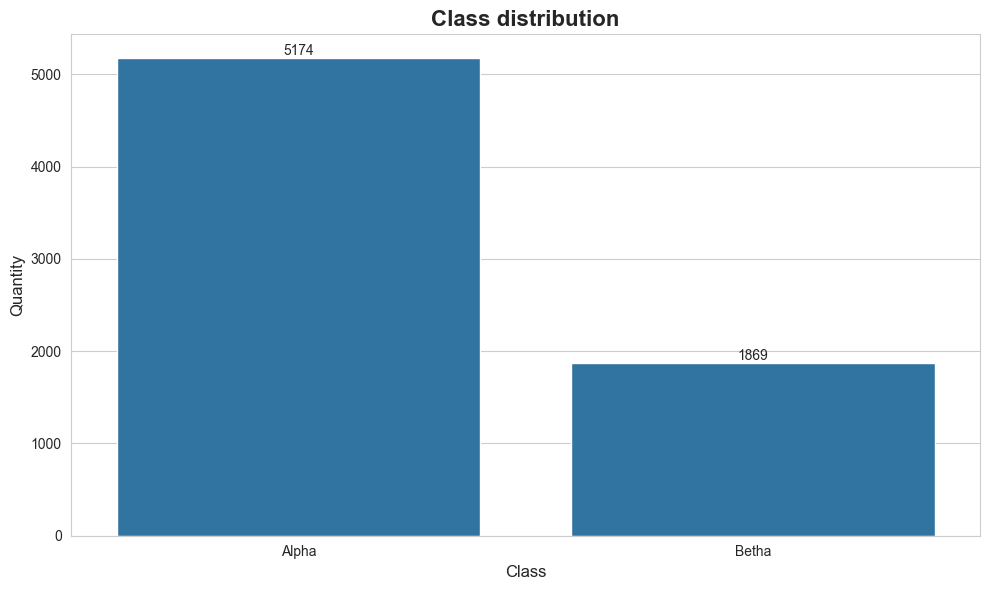

In [14]:
plt.figure(figsize=(10, 6))

ax = sns.barplot(x=data['Class'].value_counts().index, 
                 y=data['Class'].value_counts().values)

for i, v in enumerate(data['Class'].value_counts().values):
    ax.text(i, v, str(v), ha='center', va='bottom')

plt.title('Class distribution', fontsize=16, fontweight='bold')
plt.xlabel('Class', fontsize=12)
plt.ylabel('Quantity', fontsize=12)

plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

We can see that we have an imbalanced data in the betha class, so we need to use a technique to resample the amount of data

### Categorical variables coding with LabelEncoder

In [15]:
le = LabelEncoder()

for var in cat_vars:
    data[var] = le.fit_transform(data[var])

data.head()

,Partner,Dependents,Service1,Service2,Security,OnlineBackup,DeviceProtection,TechSupport,Contract,PaperlessBilling,PaymentMethod,Charges,Demand,Class
0,1,0,0,1,0,2,0,0,0,1,2,29.85,29.85,0
1,0,0,1,0,2,0,2,0,1,0,3,56.95,1889.50,0
2,0,0,1,0,2,2,0,0,0,1,3,53.85,108.15,1
3,0,0,0,1,2,0,2,2,1,0,0,42.30,1840.75,0
4,0,0,1,0,0,0,0,0,0,1,2,70.70,151.65,1


### Numerical variables normalization using StandardScaler

In [16]:
scaler = StandardScaler()
data[num_vars] = scaler.fit_transform(data[num_vars])

data[num_vars].head()

,Charges
0,-1.160323
1,-0.259629
2,-0.362660
3,-0.746535
4,0.197365


### Defining X and y variables (splitting y into y_demand and y_class)

In [17]:
X = data.drop(['Demand', 'Class'], axis=1)

y_demand = data["Demand"]
y_class = data['Class']

### Balancing data with oversampling

This oversampling will be perform in 2 phases based on the target variables:

#### Discrete variable (Class)

In [18]:
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y_class)

In [19]:
df_resampled = pd.DataFrame(X_balanced, columns=X.columns)
df_resampled['Class'] = y_balanced

In [20]:
print("Original classes distribution:", y_class.value_counts(normalize=True))
print("Balanced classes distribution:", pd.Series(y_balanced).value_counts(normalize=True))

Original classes distribution: Class
0    0.73463
1    0.26537
Name: proportion, dtype: float64
Balanced classes distribution: Class
0    0.5
1    0.5
Name: proportion, dtype: float64


In [21]:
df_resampled_full = df_resampled.merge(y_demand, left_index=True, right_index=True, how='left')

#### Continuous variable (Demand)

As we are dealing with a continuous variable, SMOTE won't work

The use of k-Nearest Neighbors (KNN) imputation is a robust technique for dealing with missing values, as it leverages information from the most similar instances to estimate missing values.

* Using contextual information: KNN imputation uses information from similar instances, which can provide more accurate estimates.

In [22]:
imputer = KNNImputer(n_neighbors=5)

df_imputed_array = imputer.fit_transform(df_resampled_full)

In [23]:
df_imputed = pd.DataFrame(df_imputed_array, columns=df_resampled_full.columns)

df_final = df_imputed.sample(frac=1, random_state=42).reset_index(drop=True)

* Data Balance: The combination of SMOTE and KNNImputer helps in maintaining balance in the discrete variable and handling missing values ​​in the continuous variable.

### Defining new X and Y variables after oversampling

In [24]:
X_oversampled = df_final.drop(['Demand', 'Class'], axis=1)

y_oversampled_class = df_final["Class"]
y_oversampled_demand = df_final["Demand"]

### PCA (Principal Components Analysis)

Dimensionality reduction technique used to reduce the number of variables in a data set, while retaining as much variability as possible

In [25]:
pca = PCA(n_components=0.95) 
X_pca = pca.fit_transform(X_oversampled)

print(f"X original shape: {X_oversampled.shape} \nX after PCA: {X_pca.shape}\n")
print(f"Number of components: {pca.n_components_} \nVariance: {pca.explained_variance_ratio_}")

X original shape: (10348, 12) 
X after PCA: (10348, 10)

Number of components: 10 
Variance: [0.24199503 0.19457693 0.11729002 0.09069218 0.08651975 0.07171588
 0.06862252 0.04482778 0.03276081 0.02623359]


Variance indicates what proportion of the total variance is captured by each principal component. This helps decide how many main components to retain.

## Model selection

### Splitting PCA components in train/test sets for demand and class

In [26]:
X_train_pca, X_test_pca, y_demand_train, y_demand_test, y_class_train, y_class_test = train_test_split(
    X_pca, y_oversampled_demand, y_oversampled_class, test_size=0.2, random_state=42
)

print("Tamaño del conjunto de entrenamiento:", X_train_pca.shape)
print("Tamaño del conjunto de prueba:", X_test_pca.shape)

Tamaño del conjunto de entrenamiento: (8278, 10)
Tamaño del conjunto de prueba: (2070, 10)


### Models for classification and regression

Classification
* Random Forest
* SVM
* XGBoost

Regression
* Random Forest
* SVR
* XGBoost

In [27]:
classifiers = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(random_state=42),
    'XGBoost': XGBClassifier(random_state=42)
}

regressors = {
    'Random Forest': RandomForestRegressor(random_state=42),
    'SVR': SVR(),
    'XGBoost': XGBRegressor(random_state=42)
}

### Evaluating models' performance using metrics

#### Classification

* Accuracy: Measures the proportion of correct predictions (both positive and negative) among the total number of cases examined. "What percentage of predictions are correct?"

* F1-score: It is the harmonic mean of precision and recall.
Provides a balance between precision (how many of the instances classified as positive are actually positive) and recall (how many of the truly positive instances were classified correctly)

* Confussion matrix: Is ​​a table that shows the classification frequencies for each class in the model. For a binary classification problem, the confusion matrix is ​​a 2x2 table

|  | Predicted Negative | Predicted Positive |
| ------ | ------ | ------ |
| True Negative | True Negative (TN) | False Positive (FP) |
| True Positive | False Negative (FN) | True Positive (TP) |

* True Negative (TN): The model correctly predicted the negative class.
* True Positive (TP): The model correctly predicted the positive class.

* False Positive (FP): The model incorrectly predicted the positive class.
* False Negative (FN): The model incorrectly predicted the negative class.

Random Forest - Accuracy: 0.7802, F1-score: 0.7802


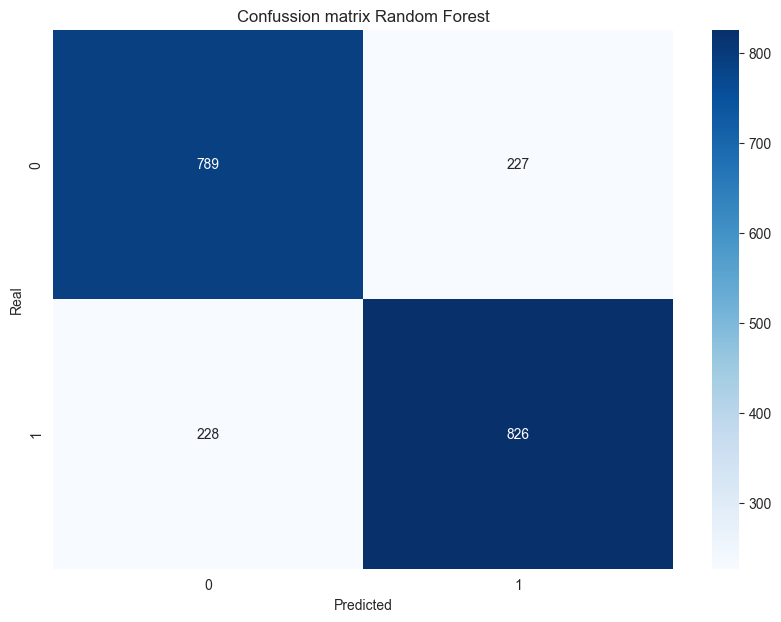

SVM - Accuracy: 0.7758, F1-score: 0.7748


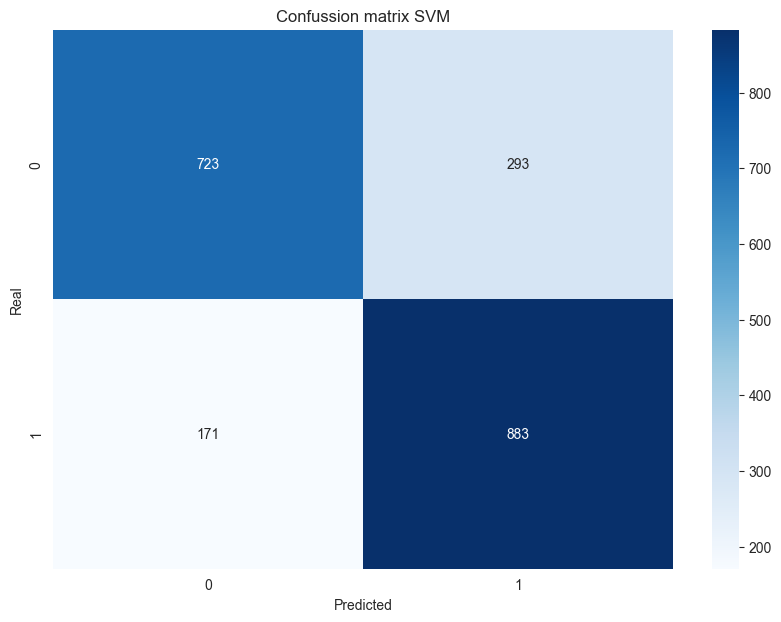

XGBoost - Accuracy: 0.7995, F1-score: 0.7992


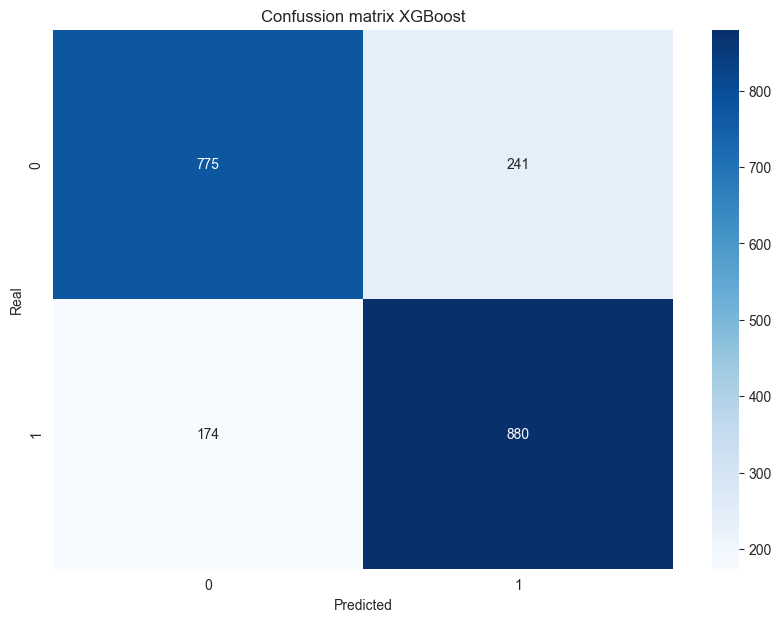

In [28]:
for name, clf in classifiers.items():
    clf.fit(X_train_pca, y_class_train)
    y_pred_class = clf.predict(X_test_pca)

    print(f"{name} - Accuracy: {accuracy_score(y_class_test, y_pred_class):.4f}, F1-score: {f1_score(y_class_test, y_pred_class, average='weighted'):.4f}")

    cm = confusion_matrix(y_class_test, y_pred_class)
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confussion matrix {name}')
    plt.ylabel('Real')
    plt.xlabel('Predicted')
    plt.show()

The model with the highest accuracy is XGBoost

#### Regression

* Mean Squared Error (MSE): It measures the mean squared errors, that is, the average squared difference between the estimated values ​​and the actual values.

* R-squared (R2): Also known as coefficient of determination.
It provides a measure of how well predictions fit actual data.
It varies between 0 and 1, where 1 indicates a perfect fit and 0 indicates that the model does not explain any variability in the data.

* Mean Absolute Error (MAE): Measures the average of the absolute differences between predictions and actual values.

In [29]:
for name, reg in regressors.items():
    reg.fit(X_train_pca, y_demand_train)
    y_pred_demand = reg.predict(X_test_pca)
    print(f"{name} \nMean Square Error (MSE): {mean_squared_error(y_demand_test, y_pred_demand):.4f} \nR-squared (R2): {r2_score(y_demand_test, y_pred_demand):.4f} \nMean Absolute Error (MAE): {mean_absolute_error(y_demand_test, y_pred_demand):.4f}\n")

Random Forest 
Mean Square Error (MSE): 863012.5041 
R-squared (R2): 0.8012 
Mean Absolute Error (MAE): 605.1431

SVR 
Mean Square Error (MSE): 3764268.7271 
R-squared (R2): 0.1328 
Mean Absolute Error (MAE): 1297.9182

XGBoost 
Mean Square Error (MSE): 854620.5871 
R-squared (R2): 0.8031 
Mean Absolute Error (MAE): 594.3049



### Cross validation

Evaluate model performance more robustly.

In [30]:
best_clf = classifiers['XGBoost']
cv_scores = cross_val_score(best_clf, X_pca, y_oversampled_class, cv=5, scoring='accuracy')
print(f"Cross Validation Accuracy for classification: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")


Cross Validation Accuracy for classification: 0.7998 (+/- 0.0241)


In [31]:
best_reg = regressors['XGBoost']
cv_scores = cross_val_score(best_reg, X_pca, y_oversampled_demand, cv=5, scoring='r2')
print(f"Cross Validation MSE for regression: {-cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

Cross Validation MSE for regression: -0.7974 (+/- 0.0148)


### Hiperparameter tuning

Optimize the hyperparameters of your models using techniques like RandomizedSearchCV.

In [32]:
param_grid_clf = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 5, 6, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.5],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.5, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.5, 0.6, 0.7, 1.0]
}

grid_search_clf = RandomizedSearchCV(XGBClassifier(random_state=42), param_grid_clf, n_iter=100, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_clf.fit(X_pca, y_oversampled_class)

print("Best parameters for classification:", grid_search_clf.best_params_)
print("Best accuracy:", grid_search_clf.best_score_)

Best parameters for classification: {'subsample': 0.8, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 0.5}
Best accuracy: 0.8037319716168982


In [33]:
param_grid_reg = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 5, 6, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.5],
    'gamma': [0, 0.1, 0.2, 0.3],
    'subsample': [0.5, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.5, 0.6, 0.7, 1.0]
}

grid_search_reg = RandomizedSearchCV(XGBRegressor(), param_grid_reg, n_iter=40, cv=5, scoring='r2', n_jobs=-1, random_state=42)
grid_search_reg.fit(X_pca, y_oversampled_demand)

print("Best parameters for regression:", grid_search_reg.best_params_)
print("Best R2 score:", grid_search_reg.best_score_)

Best parameters for regression: {'subsample': 0.5, 'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.05, 'gamma': 0.3, 'colsample_bytree': 0.6}
Best R2 score: 0.8171283216105476


### Model evaluation

In [34]:
best_clf = grid_search_clf.best_estimator_
y_pred_class_final = best_clf.predict(X_test_pca)
print("Classification - Accuracy:", accuracy_score(y_class_test, y_pred_class_final))
print("Classification - F1-score:", f1_score(y_class_test, y_pred_class_final, average='weighted'))


best_reg = grid_search_reg.best_estimator_
y_pred_demand_final = best_reg.predict(X_test_pca)
print("Regression - MSE:", mean_squared_error(y_demand_test, y_pred_demand_final))
print("Regression - R2:", r2_score(y_demand_test, y_pred_demand_final))

Classification - Accuracy: 0.9227053140096618
Classification - F1-score: 0.92253447206727
Regression - MSE: 488770.254449611
Regression - R2: 0.8874028681875636


### Save models. PCA and scaler in folder

In [35]:
from joblib import dump

dump(best_clf, '../models/xgb_classifier.joblib')
dump(best_reg, '../models/xgb_regressor.joblib')

dump(pca, '../models/pca_transformer.joblib')
dump(scaler, '../models/standard_scaler.joblib')


['../models/standard_scaler.joblib']